# Task 4

This task asks us to train a sine function model. We first implemented this based on an existing [Pennylane tutorial](https://pennylane.ai/blog/2021/10/how-to-start-learning-quantum-machine-learning/). Then we evaluated this and gave our alternative model.

The following is implemented based on the tutorial.

In [71]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

import matplotlib.pyplot as plt

np.random.seed(0)

In [33]:
X_train = np.linspace(0, 2*np.pi, 10)
Y_train = np.sin(X_train)
X_val = np.linspace(0, 2*np.pi, 1000)
Y_val = np.sin(X_val)

In [35]:
dev = qml.device('default.qubit', wires=1)

# Step 2 - Create the quantum circuit
@qml.qnode(dev)
def quantum_circuit(params, datapoint):
    # Encode the input data as an RX rotation
    qml.RX(datapoint, wires=0)
    # Create a rotation based on the angles in "params"
    qml.Rot(params[0], params[1], params[2], wires=0)
    # We return the expected value of a measurement along the Z axis
    return qml.expval(qml.PauliZ(wires=0))

In [36]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

def cost(params, X_list, Y_list):
    predictions = [quantum_circuit(params, x)  for x in X_list]
    return square_loss(Y_list, predictions)

def accuracy(params, X_list, Y_list):
    predictions = [quantum_circuit(params, x)  for x in X_list]
    return 

In [37]:
# Steps 5.1 and 5.2  - We define the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.3)

# Step 5.3 We make an initial guess for the parameters
params = np.array([0.1,0.1,0.1],requires_grad=True)

# Step 5.4 - We iterate over a number of defined steps (100)
for i in range (1000):
    # Over each step the parameters change to give a better cost
    params, _, _ = opt.step(cost, params, X_train, Y_train)
    if i%50 == 0:
         # We print the result after every 10 steps
        print(f'Step = {i}, Cost = {cost(params, X_train, Y_train)}')

Step = 0, Cost = 1.0008220305122786
Step = 50, Cost = 0.0007713203532094914
Step = 100, Cost = 0.00017248396195919063
Step = 150, Cost = 7.38963639111891e-05
Step = 200, Cost = 4.0810887949216756e-05
Step = 250, Cost = 2.583238372634074e-05
Step = 300, Cost = 1.780734986246756e-05
Step = 350, Cost = 1.3014033334755201e-05
Step = 400, Cost = 9.924375322652338e-06
Step = 450, Cost = 7.817236721627177e-06
Step = 500, Cost = 6.31625809478156e-06
Step = 550, Cost = 5.2094301198222625e-06
Step = 600, Cost = 4.3699318949256335e-06
Step = 650, Cost = 3.718128669912878e-06
Step = 700, Cost = 3.20197143604839e-06
Step = 750, Cost = 2.7862769323936345e-06
Step = 800, Cost = 2.4465707059739726e-06
Step = 850, Cost = 2.165401291431658e-06
Step = 900, Cost = 1.9300537696598063e-06
Step = 950, Cost = 1.7310868831418145e-06


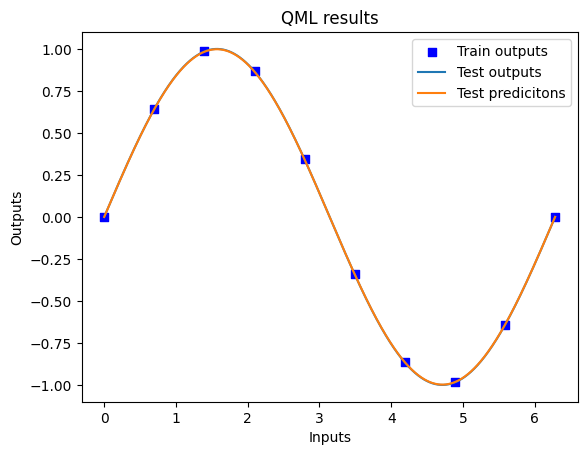

In [38]:
test_predictions =  [quantum_circuit(params, x)  for x in X_val]

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X_train, Y_train, c='b', marker="s", label='Train outputs')
ax1.plot(X_val,Y_val, label='Test outputs')
ax1.plot(X_val,test_predictions, label='Test predicitons')
plt.xlabel("Inputs")
plt.ylabel("Outputs")
plt.title("QML results")

plt.legend(loc='upper right')
plt.show()

However, scrutinising the quantum ansatz,

```
@qml.qnode(dev)
def quantum_circuit(params, datapoint):
    # Encode the input data as an RX rotation
    qml.RX(datapoint, wires=0)
    # Create a rotation based on the angles in "params"
    qml.Rot(params[0], params[1], params[2], wires=0)
    # We return the expected value of a measurement along the Z axis
    return qml.expval(qml.PauliZ(wires=0))
```

We see that this ansatz utilises a rotation around the X-axis, then a trainable rotation, then finds the expectation value of measuring along the Z-axis. Considering the Bloch Sphere, we realise that the RX gate essentially converts the original `datapoint` to `cos(datapoint)` when viewed in the Z-axis, i.e. creates a cosine curve. The trainable rotation simply translates or scales this cosine curve. 

The following graph shows some examples of the transformation. The lables are the parameters given to the `Rot` gate.


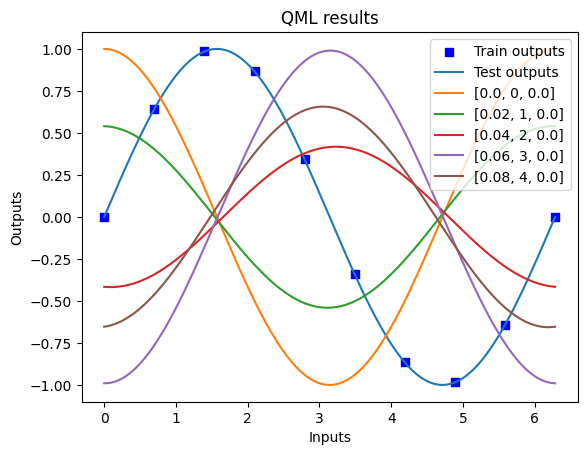

In [70]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(X_val,Y_val, label='Test outputs')
for i in range(5):
    test_predictions = [quantum_circuit([i/50,i,0.0], x)  for x in X_val]
    ax1.plot(X_val,test_predictions, label=str([i/50,i,0.0]))

test_predictions =  [quantum_circuit([i/50,i,0.0], x)  for x in X_val]
ax1.plot(X_val,test_predictions, label=str([i/50,i,0.0]))
plt.xlabel("Inputs")
plt.ylabel("Outputs")
plt.title("QML results")

plt.legend(loc='upper right')
plt.show()

In [80]:
print(f'phi, theta, omega = {params[0]}, {params[1]}, {params[2]}')
print(f'phi, theta, omega (in degrees) = {params[0]/np.pi * 180}, {params[1]/np.pi * 180}, {params[2]/np.pi * 180}')

phi, theta, omega = -1.5097197879042852, 1.5707963267948966, 0.09999999999999999
phi, theta, omega (in degrees) = -86.50057209430133, 90.0, 5.729577951308232


Consider the `Rot` gate $R(\phi, \theta, \omega) = RZ(\omega)RZ(\theta)RZ(\phi)$. The final expectation value is calculated along the Z axis, thus the final $RZ(\omega)$ rotation does not affect our measurement. The other rotations approximate to a $-\frac{\pi}{2}$ rotation around the Z axis followed by a $\frac{\pi}{2}$ rotation around the Y axis. Considering the Bloch sphere, this essentially is a transformation from a cosine graph to a sine graph.

Given that our ansatz directly converts the `X` data into its cosine, and only the transformation from the cosine to the sine function is trained, this is equivalent to a trainable trigonometric ansatz and a rather uninteresting use of QML. This application of QML is an especially inefficient given that a relatively large number of shots is required to find the expectation value used in this model.

In [ ]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from tqdm import tqdm, trange

bs = 128
lr = 0.01
steps = 1000

model = nn.Sequential(
	nn.Linear(1, 100),
	nn.ReLU(),
	nn.Linear(100, 1)
)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, steps, eta_min=lr * 0.01)

for i in trange(1000):
	x = torch.rand(bs) * 2 * 3.1415
	y = torch.sin(x)

	y_pred = model(x.unsqueeze(1))
	loss = loss_fn(y_pred.squeeze(), y)

	optimizer.zero_grad(True)
	loss.backward()
	optimizer.step()

	if i % 100 == 0:
		tqdm.write(f'{loss.item():.4f}')

x = torch.linspace(0, 2 * 3.1415, 10000)
y = torch.sin(x)
y_pred = model(x.unsqueeze(1)).detach()

plt.plot(x, y)
plt.plot(x, y_pred)
plt.show()